In [36]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [37]:
from datasets import load_dataset

dataset = load_dataset('emotion')

In [38]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [39]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [40]:
def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [41]:
tweets, labels = get_tweets(train)

In [42]:
tweets[10], labels[10]

('i feel like i have to make the suffering i m seeing mean something', 0)

In [43]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

tokenizer.fit_on_texts(tweets)

print(tokenizer.texts_to_sequences([tweets[10]]))

[[2, 3, 14, 2, 21, 5, 80, 6, 733, 2, 93, 544, 304, 84]]


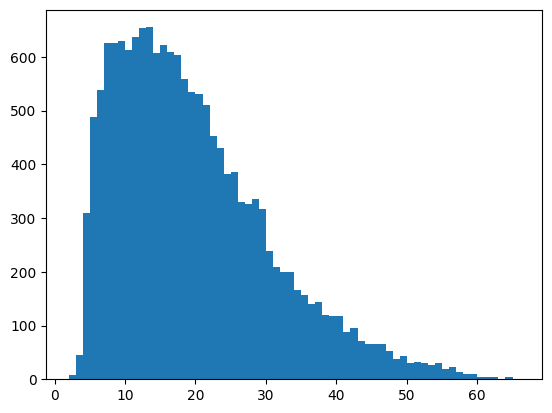

In [44]:
lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [45]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [46]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=40, padding='post')
    return padded_sequences

In [47]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [ ]:
padded_train_sequences[10]

array([  2,   3,  14,   2,  21,   5,  80,   6, 733,   2,  93, 544, 304,
        84,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0], dtype=int32)

In [48]:
classes = set(labels)
print(classes)

{0, 1, 2, 3, 4, 5}


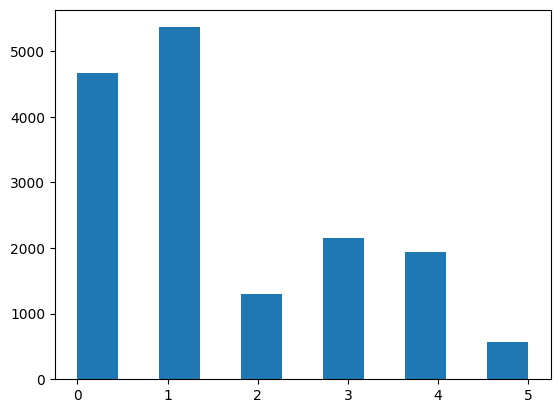

In [49]:
plt.hist(labels, bins=11)
plt.show()

In [ ]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [ ]:
classes_to_index

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [ ]:
index_to_classes

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [ ]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [ ]:
train_labels = names_to_ids(labels)
print(train_labels[10])

0


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=40),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [50]:
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [51]:
val_tweets[20], val_labels[20]

('i just know to begin with i am going to feel shy about it', np.int64(4))

In [52]:
h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9858 - loss: 0.0459 - val_accuracy: 0.8900 - val_loss: 0.4479
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9883 - loss: 0.0358 - val_accuracy: 0.8855 - val_loss: 0.4198
Epoch 3/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9848 - loss: 0.0426 - val_accuracy: 0.8965 - val_loss: 0.3911
Epoch 4/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9905 - loss: 0.0297 - val_accuracy: 0.8910 - val_loss: 0.4715
Epoch 5/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9918 - loss: 0.0261 - val_accuracy: 0.8920 - val_loss: 0.4498


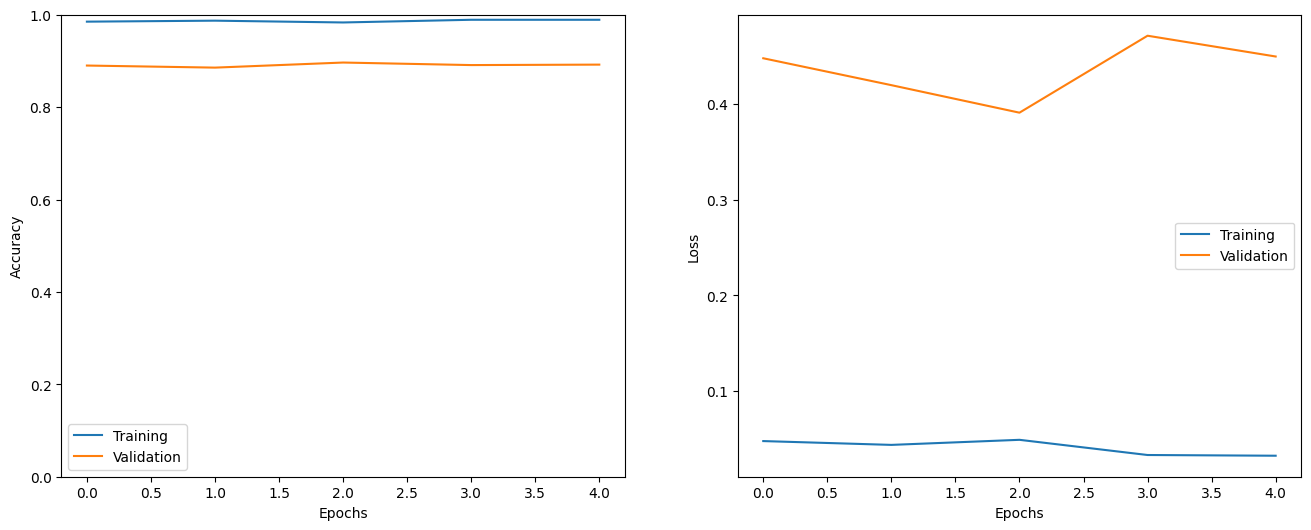

In [53]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

show_history(h)

In [54]:
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [55]:
eval = model.evaluate(test_sequences, test_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8826 - loss: 0.4901


In [62]:
classes = sorted(set(labels))  # ensure consistent order
classes_to_index = {c: i for i, c in enumerate(classes)}
index_to_classes = {i: c for c, i in classes_to_index.items()}

In [68]:
from sklearn.metrics import classification_report
import numpy as np

y_pred_probs = model.predict(test_sequences)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.array(test_labels)
print(type(y_pred))
print(type(y_true))

# Convert integer labels back to class names
##target_names = [index_to_classes[i] for i in range(len(classes))]

print(classification_report(y_true, y_pred, target_names=list(['0','1','2','3','4','5'])))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       581
           1       0.93      0.89      0.91       695
           2       0.71      0.80      0.75       159
           3       0.82      0.92      0.87       275
           4       0.83      0.82      0.82       224
           5       0.67      0.74      0.71        66

    accuracy                           0.88      2000
   macro avg       0.82      0.85      0.83      2000
weighted avg       0.89      0.88      0.88      2000



In [63]:
for a in range(0,5):
  i = random.randint(0, len(test_labels) - 1)

  print('Tweet:', test_tweets[i])
  print('Actual Emotion:', index_to_classes[test_labels[i]])

  p = model.predict(np.expand_dims(test_sequences[i], axis=0))[0]

  # Get the index of the predicted emotion
  predicted_emotion_index = np.argmax(p)

  print('Predicted Emotion:', index_to_classes.get(predicted_emotion_index), '\n')

Tweet: i feel so talented i can use a computer
Actual Emotion: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Emotion: 1 

Tweet: i have found myself overwhelmed with jealousy and self contempt and i have found myself feeling this towards the lives of my sweet friends and acquaintances as portrayed on social media
Actual Emotion: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Emotion: 4 

Tweet: i feel annoyingly isolated in the hostel with all those people talking outside the room etc
Actual Emotion: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Emotion: 0 

Tweet: i feel lost and then found november i have told jamie this several times
Actual Emotion: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Emotion: 0 

Tweet: i suppose we all feel a little inhibited when it comes to picking up the phone and calling someone we re not very close to anymore
Actual Emotion: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Emotion: 0 

